In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install torch
!pip install pytorch-lightning
!pip install pytorch-forecasting
!pip install shap
!pip install stable-baselines3
!pip install "shimmy>=2.0"


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
  Using cached s

In [ ]:
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
pip install tensorboard


Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install stable-baselines3



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


**LIBRARIES**

In [ ]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# PyTorch & Lightning
import torch
import torch.nn as nn
from torch.optim import Adam
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
# Pytorch Forecasting (TFT & utilities)
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, GroupNormalizer, Baseline, QuantileLoss
# Reinforcement Learning (Stable Baselines3)
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
# Gym (for environment)
import gym
from gym import spaces
# Extra (for SB3 compatibility)
import shimmy  # Ensures Gym + Gymnasium compatibility

**LOADING**

In [ ]:
# Load datasets
sales_df = pd.read_csv("sales_train_validation.csv")
calendar_df = pd.read_csv("calendar.csv")
prices_df = pd.read_csv( "sell_prices.csv")

# Check shapes
print(f"Sales data shape: {sales_df.shape}")
print(f"Calendar data shape: {calendar_df.shape}")
print(f"Prices data shape: {prices_df.shape}")

# Quick look at data
print(sales_df.head())
print(calendar_df.head())
print(prices_df.head())

Sales data shape: (30490, 1919)
Calendar data shape: (1969, 14)
Prices data shape: (6841121, 4)
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0   

In [ ]:
# Filter by 1 store and top 30 item IDs
selected_store = 'CA_1'
selected_items = sales_df[sales_df['store_id'] == selected_store]['item_id'].unique()[:30]
sales_df_small = sales_df[
    (sales_df['store_id'] == selected_store) &
    (sales_df['item_id'].isin(selected_items))]

# Ensure date column is datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

# Get last N days of 'd' columns (e.g., last 180 days)
recent_dates = calendar_df['date'].sort_values().unique()[-180:]
recent_days = calendar_df[calendar_df['date'].isin(recent_dates)]['d'].unique().tolist()

# Only keep the sales columns for those days + identifier columns
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
available_days = [col for col in recent_days if col in sales_df_small.columns]
filtered_sales = sales_df_small[id_cols + available_days]

# Melt the sales data to long format
sales_long = pd.melt(filtered_sales,
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='d', value_name='sales')

# Merge with calendar and price data
sales_calendar = sales_long.merge(calendar_df, how='left', on='d')
full_data = sales_calendar.merge(prices_df, how='left', on=['store_id', 'item_id', 'wm_yr_wk'])

# Check merged data shape and a sample
print(f"Merged data shape: {full_data.shape}")
print(full_data.head())

Merged data shape: (3720, 22)
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id       d  sales       date  wm_yr_wk  ... month  year  event_name_1  \
0       CA  d_1790      3 2015-12-23     11547  ...    12  2015           NaN   
1       CA  d_1790      3 2015-12-23     11547  ...    12  2015           NaN   
2       CA  d_1790      2 2015-12-23     11547  ...    12  2015           NaN   
3       CA  d_1790      0 2015-12-23     11547  ...    12  2015           NaN   
4       CA  d_1790      3 2015-12-23     11547  ...    12  2015           NaN   

  

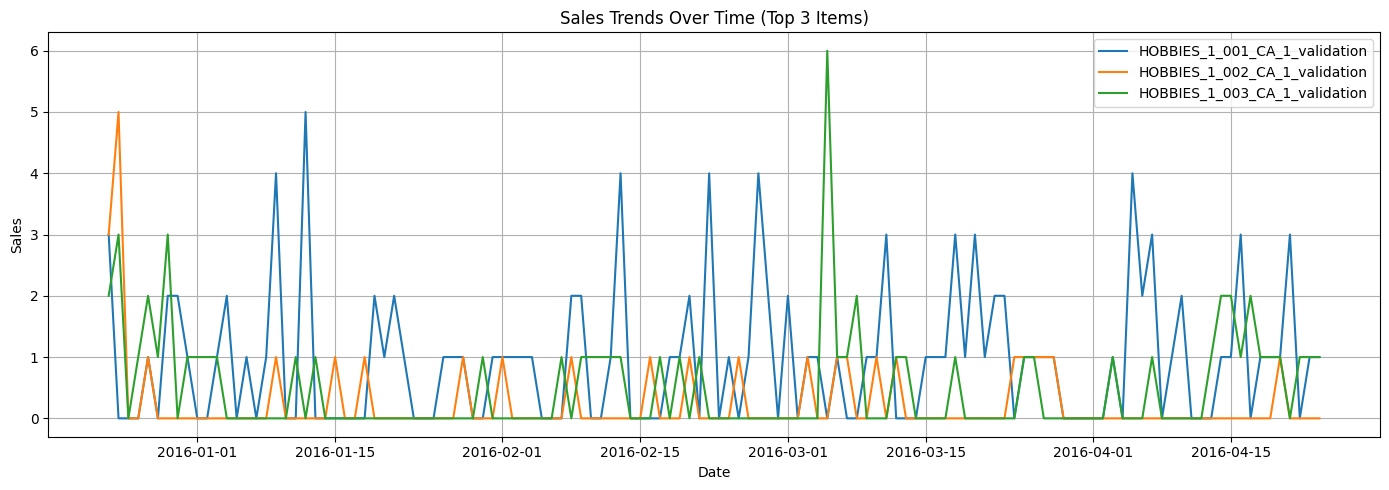

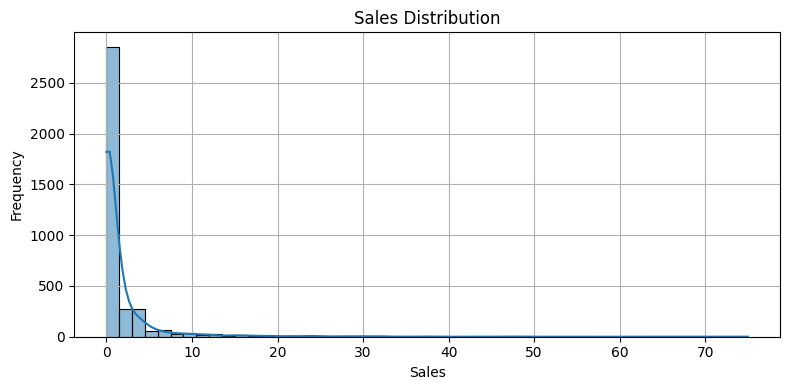

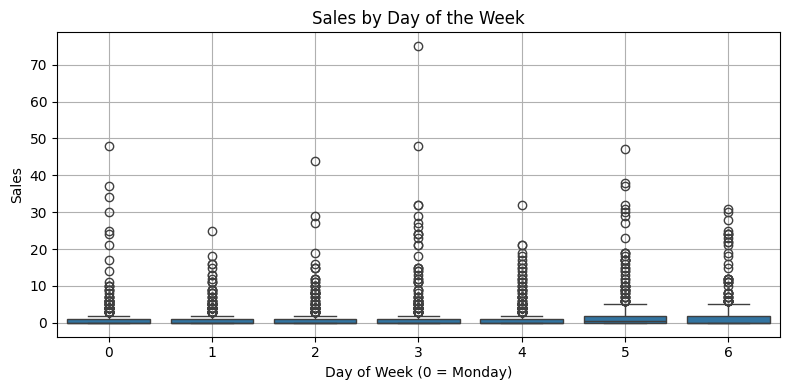

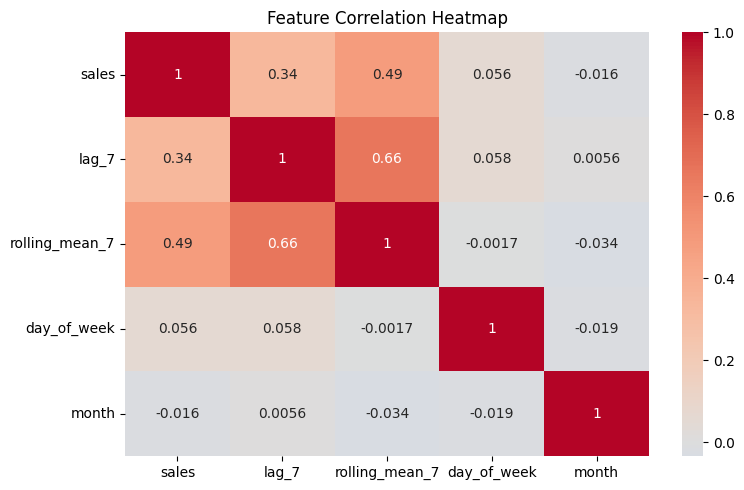

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'full_data' is already loaded
full_data["date"] = pd.to_datetime(full_data["date"])
full_data["day_of_week"] = full_data["date"].dt.dayofweek  # Monday=0
full_data["month"] = full_data["date"].dt.month
full_data["lag_7"] = full_data.groupby("id")["sales"].shift(7)
full_data["rolling_mean_7"] = full_data.groupby("id")["sales"].transform(
    lambda x: x.shift(7).rolling(7).mean())

#1. Sales Trends for Sample Items
sample_items = full_data["id"].unique()[:3]
sample_df = full_data[full_data["id"].isin(sample_items)]

plt.figure(figsize=(14, 5))
for item in sample_items:
    item_df = sample_df[sample_df["id"] == item]
    plt.plot(item_df["date"], item_df["sales"], label=item)
plt.title("Sales Trends Over Time (Top 3 Items)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#2. Sales Distribution
plt.figure(figsize=(8, 4))
sns.histplot(full_data["sales"], bins=50, kde=True)
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#3. Boxplot of Sales by Day of Week
plt.figure(figsize=(8, 4))
sns.boxplot(x="day_of_week", y="sales", data=full_data)
plt.title("Sales by Day of the Week")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

#4. Correlation Heatmap
numeric_cols = ["sales", "lag_7", "rolling_mean_7", "day_of_week", "month"]
corr = full_data[numeric_cols].corr()
plt.figure(figsize=(8, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# 1. Ensure 'date' is datetime
full_data['date'] = pd.to_datetime(full_data['date'])

# 2. Create a time index for TFT (days since first date)
full_data['time_idx'] = (full_data['date'] - full_data['date'].min()).dt.days

# 3. Sort for lag features
full_data = full_data.sort_values(by=['id', 'date'])

# 4. Create lag features
LAG_DAYS = [7]
for lag in LAG_DAYS:
    full_data[f'lag_{lag}'] = full_data.groupby('id')['sales'].shift(lag)

# 5. Create rolling mean features
ROLLING_WINDOWS = [7]
for window in ROLLING_WINDOWS:
    full_data[f'rolling_mean_{window}'] = (
        full_data.groupby('id')['sales']
        .shift(1)  # shift by 1 to avoid using current day's value
        .rolling(window)
        .mean()
        .reset_index(drop=True))

# 6. Create date-based features
full_data['day_of_week'] = full_data['date'].dt.dayofweek
full_data['week_of_year'] = full_data['date'].dt.isocalendar().week.astype('int16')
full_data['month'] = full_data['date'].dt.month
full_data['year'] = full_data['date'].dt.year

# 7. Encode categorical features
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
for col in cat_cols:
    full_data[col] = full_data[col].astype(str)  # Optionally: use LabelEncoder

# 8. Filter IDs with enough data history (>= 30 days)
min_required_days = 30
id_counts = full_data['id'].value_counts()
valid_ids = id_counts[id_counts > min_required_days].index
full_data = full_data[full_data['id'].isin(valid_ids)].copy()

# 9. Drop rows with NaNs in lag/rolling features only
required_columns = ['lag_7', 'rolling_mean_7']
full_data = full_data.dropna(subset=required_columns).reset_index(drop=True)

# 10. Print check
print(f"✅ Final feature-engineered shape: {full_data.shape}")
print(full_data[['sales', 'lag_7', 'rolling_mean_7', 'day_of_week', 'month']].head())

✅ Final feature-engineered shape: (3314, 27)
   sales  lag_7  rolling_mean_7  day_of_week  month
0      2    3.0        0.142857            2     12
1      1    0.0        0.000000            3     12
2      0    0.0        0.285714            4      1
3      0    0.0        0.714286            5      1
4      1    1.0        0.714286            6      1


In [ ]:
# Convert relevant categorical columns to string
categorical_columns = [
    "item_id", "store_id", "id",
    "event_name_1", "event_type_1",
    "day_of_week"  # corrected from "weekday"]
for col in categorical_columns:
    if col in full_data.columns:
        full_data[col] = full_data[col].astype(str)

print("✅ Cleaned and converted all categorical columns to string type")

✅ Cleaned and converted all categorical columns to string type


In [ ]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
# Create the TimeSeriesDataSet object

tft_dataset = TimeSeriesDataSet(
    full_data,
    time_idx="time_idx",
    target="sales",
    group_ids=["id"],

    max_encoder_length=30,
    max_prediction_length=7,

    static_categoricals=["item_id", "store_id", "dept_id", "cat_id", "state_id"],

    time_varying_known_reals=["time_idx", "month", "year", "day_of_week"],
    time_varying_unknown_reals=["sales", "lag_7", "rolling_mean_7"],

    target_normalizer=GroupNormalizer(groups=["id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)
print("✅ TFT dataset prepared:", tft_dataset)

✅ TFT dataset prepared: <pytorch_forecasting.data.timeseries.TimeSeriesDataSet object at 0x174b800a0>


In [ ]:
from pytorch_lightning import seed_everything
from torch.utils.data import DataLoader

# Set seed for reproducibility
seed_everything(42, workers=True)

# Define cutoff point for training vs. validation
train_cutoff = full_data["time_idx"].max() - 7  # 7 = max_prediction_length

# Use decoded_index-compatible columns
training = tft_dataset.filter(lambda x: x["time_idx_last"] <= train_cutoff)
validation = tft_dataset.filter(lambda x: x["time_idx_first_prediction"] > train_cutoff)

# Create dataloaders
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=0)

print("✅ Training and validation dataloaders created successfully")


Global seed set to 42


✅ Training and validation dataloaders created successfully


In [ ]:
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# Set logger and callbacks
logger = TensorBoardLogger("lightning_logs", name="tft_m5_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor(logging_interval="epoch")

# Define TFT model
tft = TemporalFusionTransformer.from_dataset(
    tft_dataset,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # use 7 for QuantileLoss
    loss=QuantileLoss(),  # You can also try QuantileLoss(), RMSE etc.
    log_interval=10,
    reduce_on_plateau_patience=4)

# Trainer for 30 epochs with GPU if available
trainer = Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    gradient_clip_val=0.1,
    limit_train_batches=1.0,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

# Train the model
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

print("✅ Training complete. You can now proceed to evaluation and interpretation.")


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 334   
3  | prescalers                         | ModuleDict                      | 176   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 5.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.0 K 
7

Sanity Checking: 0it [00:00, ?it/s]

/Users/krishnakoushikunnam/.pyenv/versions/retail_ai_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 11 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/krishnakoushikunnam/.pyenv/versions/retail_ai_env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.391


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.038 >= min_delta = 0.0001. New best score: 0.353


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.353. Signaling Trainer to stop.


✅ Training complete. You can now proceed to evaluation and interpretation.


In [ ]:
import torch
import torch.nn.functional as F
from pytorch_forecasting.metrics import SMAPE

# Load best model
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

# Get predictions
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Get decoder targets
targets = x["decoder_target"]

# Filter only aligned samples where both pred and target exist
aligned = [(p, t) for p, t in zip(raw_predictions, targets) if p.numel() > 0 and t.numel() > 0]

# Determine max length for padding
max_len = max(p.numel() for p, t in aligned)

# Pad and stack predictions
predictions = torch.stack([
    F.pad(p.flatten(), (0, max_len - p.numel()), value=0)
    for p, t in aligned
])

# Pad and stack actual targets
actuals = torch.stack([
    F.pad(t.flatten(), (0, max_len - t.numel()), value=0)
    for p, t in aligned
])

# Compute SMAPE
if predictions.shape == actuals.shape:
    smape = SMAPE()(predictions, actuals)
    print(f"✅ SMAPE on validation set: {smape:.3f}")
else:
    print("❌ Shape mismatch:", predictions.shape, actuals.shape)


✅ SMAPE on validation set: 0.589


/Users/krishnakoushikunnam/.pyenv/versions/retail_ai_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/krishnakoushikunnam/.pyenv/versions/retail_ai_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


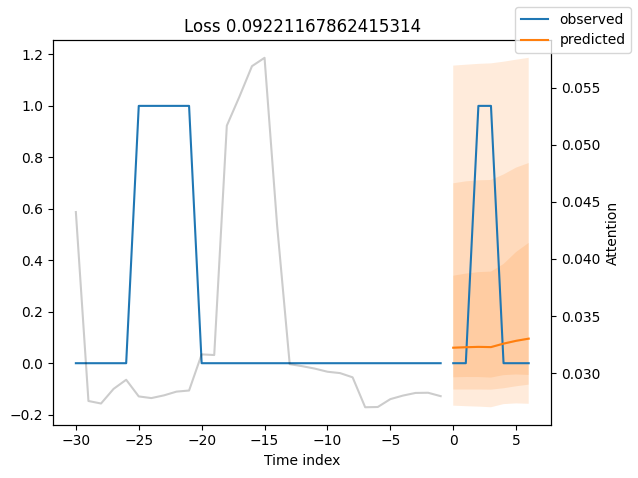

In [ ]:
import matplotlib.pyplot as plt

# Get predictions from the model
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

# Plot attention for one example (e.g., the first sample)
fig = best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True)
plt.show()

In [ ]:
class PricingEnv(gym.Env):
    def __init__(self, demand_data, cost_price=1.0, price_points=None, max_inventory=200):
        super(PricingEnv, self).__init__()
        self.demand_data = demand_data
        self.cost_price = cost_price
        self.price_points = price_points if price_points is not None else np.linspace(1.0, 10.0, 10)
        self.max_inventory = max_inventory

        self.action_space = spaces.Discrete(len(self.price_points))
        self.observation_space = spaces.Box(
            low=0,
            high=np.array([self.max_inventory, np.max(demand_data), len(demand_data)]),
            shape=(3,),
            dtype=np.float32)
        self.reset()
    def reset(self):
        self.current_step = 0
        self.inventory = self.max_inventory
        return self._get_obs()
    def _get_obs(self):
        return np.array([
            self.inventory,
            self.demand_data[self.current_step],
            self.current_step
        ], dtype=np.float32)
    def step(self, action):
        price = self.price_points[action]
        demand = self.demand_data[self.current_step]
        sold = min(demand, self.inventory)

        revenue = price * sold
        cost = self.cost_price * sold
        reward = revenue - cost

        self.inventory -= sold
        self.current_step += 1
        done = self.current_step >= len(self.demand_data) or self.inventory <= 0

        return self._get_obs(), reward, done, {}

In [ ]:
import gym
from gym import spaces
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Sample demand data (use any item ID with sufficient data)
sample_demand = full_data[full_data['id'] == 'HOBBIES_1_001_CA_1_validation']['sales'].values[:500]

# Initialize environment
env = PricingEnv(demand_data=sample_demand, cost_price=1.0, max_price=10.0, max_inventory=200)

# Wrap with DummyVecEnv (required by Stable Baselines3)
vec_env = DummyVecEnv([lambda: env])
from stable_baselines3.common.vec_env import VecNormalize
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

# Train PPO agent
ppo_agent = PPO("MlpPolicy", vec_env, verbose=1)
ppo_agent.learn(total_timesteps=10000)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5963 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 4716        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007988317 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.00118     |
|    learning_rate        | 0.0003      |
|    loss                 | 0.313       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0121     |
|    std                  | 1           |
|    value_loss           | 0.308       |
-----------------

In [ ]:
oobs = vec_env.reset()
total_rewards = []
prices = []
demands = []
for _ in range(len(sample_demand)):
    action, _states = ppo_agent.predict(obs)
    price = float(action[0])  # Extract price
    prices.append(price)

    obs, reward, done, info = vec_env.step(action)
    total_rewards.append(reward[0])

    # Extract demand (from observation)
    demand = obs[0][0]  # assuming forecasted_demand is the first element
    demands.append(demand)

    if done[0]:
        break

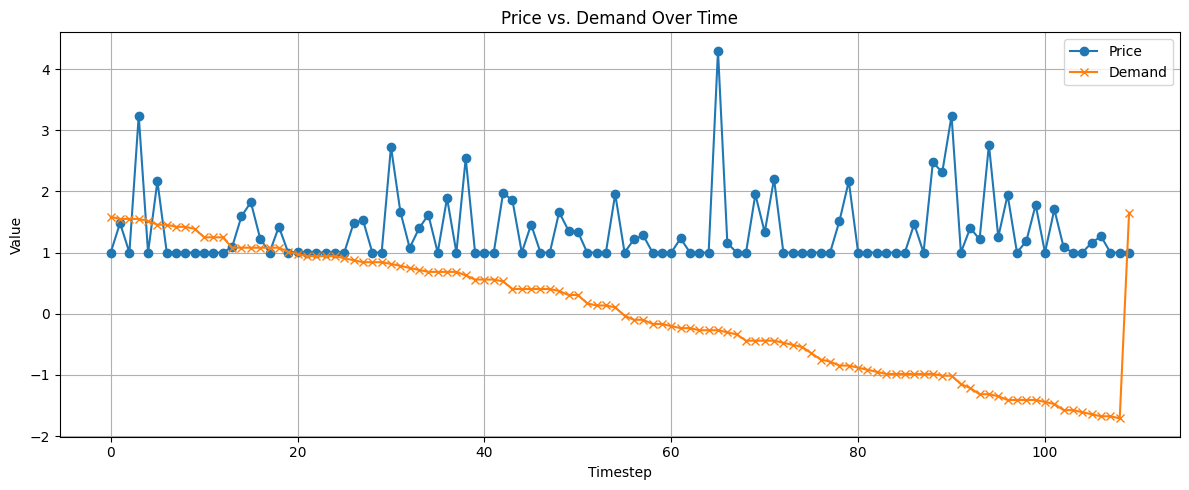

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(prices, label="Price", marker='o')
plt.plot(demands, label="Demand", marker='x')
plt.title("Price vs. Demand Over Time")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
